In [1]:
import pandas as pd 
import numpy as np
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc 
from causallearn.utils.cit import chisq
from causallearn.utils.cit import gsq
from causallearn.utils.cit import kci
from causallearn.utils.cit import fisherz

from matplotlib import pyplot as plt
from causallearn.utils.GraphUtils import GraphUtils

/home/cc/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [154]:
#read csv - on first run 
slurm_path = "/home/cc/CS520_Project/slurm-log.csv"
df = pd.read_csv(slurm_path)
#second run saved csv so you can avoid preproc



In [8]:
#Preprocessing
#Discretizing continuous variables 
#Picking columns 
#deriving new columns - system load, runtime, node hours, user job frequency,
#Handling missing values
#try different configurations of FCI

#calculate system load as count of jobs running at a given time

def calculate_system_load(df):
    for index, row in df.iterrows():
        start_time = row['time_start']
        end_time = row['time_end']
        system_load = df[(df['time_start'] <= end_time) & (df['time_end'] >= start_time)].shape[0]
        df.at[index, 'system_load'] = system_load
    return df
df = calculate_system_load(df)

In [12]:
#preprocess
df_grouped = df.groupby('id_user').agg({'id_job': 'count'}).reset_index().rename(columns={'id_job': 'user_job_frequency'})
df = pd.merge(df, df_grouped, on='id_user', how='left') 
df['runtime'] = ( df['time_end']- df['time_start'])/3600
df['node_hours'] = df['nodes_alloc'] * df['runtime']
#if exit_code is not 0 add status column as 1 and 0 if exit code is 0
df['status'] = df['exit_code'] 
df['status'] = (df['status'] != 0).astype(int)
#df = calculate_system_load(df)
#num_alloc_gpus 
df["num_alloc_gpus"] = (df[df["tres_alloc"].str.contains("1001=") | df["tres_alloc"].str.contains("1002=")]["tres_alloc"]
                                            .str.split(",").str[-1]
                                            .str.split("=").str[-1].astype(float)) #Test this so it does not catch any other tres alloc col
df["num_alloc_gpus"] = df["num_alloc_gpus"].fillna(0)
df['cpus_alloc'] = df["tres_alloc"].str.split(",").str[0].str.split("=").str[-1].astype(int)
df['mem_alloc'] = df["tres_alloc"].str.split(",").str[1].str.split("=").str[-1].astype(int)

0         170000
1         170000
2         170000
3         340000
4         170000
           ...  
395909     51200
395910     51200
395911     51200
395912     51200
395913     51200
Name: tres_alloc, Length: 395914, dtype: int64

In [13]:
#save csv with new cols
df.to_csv('slurm_log_buff.csv')

In [155]:
#START EXPERIMENTS FROM HERE INSTEAD OF BEGINNING IF NEW COLS HAVE BEEN ADDED
slurm_buff_path = "/home/cc/CS520_Project/slurm_log_buff.csv"
df = pd.read_csv(slurm_buff_path)

In [158]:
select_cols = ['nodes_alloc', 
'cpus_alloc', 
'mem_alloc', 
'partition',
'num_alloc_gpus',
 #'priority',
 #'timelimit', 
 #'job_type', 
 'runtime',
 'system_load',
 'node_hours',
 'user_job_frequency',
 'status'] 
df_res = df[select_cols]

In [159]:
#df_res['partition'] = df_res['partition'].astype('category

In [160]:
#categorical vars encode
#df_res['job_type'] = df_res['job_type'].astype('category')
#df_res['job_type'] = df_res['job_type'].cat.codes
df_res['partition'] = df_res['partition'].astype('category')
df_res['partition'] = df_res['partition'].cat.codes
df_res['status'] = df_res['status'].astype('category').cat.codes
#df_res['priority'] = df_res['priority'].astype('category')
#df_res['priority'] = df_res['priority'].cat.codes


/tmp/ipykernel_17530/3301143803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['partition'] = df_res['partition'].astype('category')
/tmp/ipykernel_17530/3301143803.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['partition'] = df_res['partition'].cat.codes
/tmp/ipykernel_17530/3301143803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [77]:
#normalize

In [161]:
df_res['runtime_bin'] = pd.cut(np.log1p(df_res['runtime']), bins=5, labels=False)
df_res['mem_alloc_bin'] = pd.qcut(np.log1p(df_res['mem_alloc']), q=4, labels=False)
df_res['node_hours_bin'] = pd.cut(np.log1p(df_res['node_hours']), bins=5, labels=False)
#df_res['system_load_bin'] = pd.qcut(np.log1p(df_res['system_load']), q=4, labels=False)
#df_res['user_job_freq_bin'] = pd.qcut(np.log1p(df_res['user_job_frequency']), q=4, labels=False)


/tmp/ipykernel_17530/2689401172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['runtime_bin'] = pd.cut(np.log1p(df_res['runtime']), bins=5, labels=False)
/tmp/ipykernel_17530/2689401172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['mem_alloc_bin'] = pd.qcut(np.log1p(df_res['mem_alloc']), q=4, labels=False)
/tmp/ipykernel_17530/2689401172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [162]:
final_df = df_res[[
    'nodes_alloc', 'cpus_alloc', 'mem_alloc_bin',
    # 'partition',
    'num_alloc_gpus', 
    'runtime_bin', 
    'node_hours_bin',
     'status', 
     'user_job_frequency',
     'system_load'
]]
final_df

,nodes_alloc,cpus_alloc,mem_alloc_bin,num_alloc_gpus,runtime_bin,node_hours_bin,status,user_job_frequency,system_load
0,1,20,3,0.0,0,0,0,7972,1.0
1,1,20,3,0.0,0,0,0,7972,2.0
2,1,20,3,0.0,0,0,0,7972,2.0
3,1,40,3,0.0,0,0,1,479,155.0
4,1,20,3,0.0,0,0,0,7972,3.0
...,...,...,...,...,...,...,...,...,...
395909,1,1,2,0.0,0,0,0,375,26.0
395910,1,1,2,0.0,0,0,0,375,24.0
395911,1,1,2,0.0,0,0,0,375,23.0
395912,1,1,2,0.0,0,0,0,375,23.0


In [72]:
#NOT DOING THIS RN 
'''consensus_subsample(data,algo='FCI',ci_test = gsq, alpha = 0.05, subsample_size = 100000, n_subsamples = 20 , edge_freq_thres= 0.5):
    rng = np.random.default_rng(0)
    graphs = []
    for i in range(n_subsamples):
        idx = rng.choice(data.shape[0], size=subsample_size, replace=False)
        data_sub = arr[idx, :]
        if algo.upper() == 'FCI' :
            g, _ = fci(data_sub,ci_test,alpha = alpha)
        else:
            g = pc(data_sub,ci_test, alpha = alpha)
        graphs.append(g)

    edge_counts = Counter()
    for g in graphs:
        for e in g.G.graph:
            edge_counts()
            
'''
for i in final_df.columns:
    final_df [i]= final_df[i].astype(int)

/tmp/ipykernel_17530/3121138351.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df [i]= final_df[i].astype(int)
/tmp/ipykernel_17530/3121138351.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df [i]= final_df[i].astype(int)
/tmp/ipykernel_17530/3121138351.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [73]:
final_df['status'].unique()

array([0, 1])

In [163]:
data = final_df.to_numpy()

In [137]:
final_df

,nodes_alloc,cpus_alloc,mem_alloc,num_alloc_gpus,runtime,system_load,node_hours,user_job_frequency,status
0,-0.017549,0.011905,0.048674,-0.111351,-0.248625,-0.567428,-0.165091,-0.360043,0
1,-0.017549,0.011905,0.048674,-0.111351,-0.247621,-0.566935,-0.164490,-0.360043,0
2,-0.017549,0.011905,0.048674,-0.111351,-0.248410,-0.566935,-0.164963,-0.360043,0
3,-0.017549,0.062087,0.151129,-0.111351,-0.208657,-0.491466,-0.141164,-0.791236,1
4,-0.017549,0.011905,0.048674,-0.111351,-0.248636,-0.566441,-0.165098,-0.360043,0
...,...,...,...,...,...,...,...,...,...
395909,-0.017549,-0.035768,-0.022923,-0.111351,-0.247790,-0.555096,-0.164591,-0.797221,0
395910,-0.017549,-0.035768,-0.022923,-0.111351,-0.245162,-0.556083,-0.163018,-0.797221,0
395911,-0.017549,-0.035768,-0.022923,-0.111351,-0.247305,-0.556576,-0.164301,-0.797221,0
395912,-0.017549,-0.035768,-0.022923,-0.111351,-0.246639,-0.556576,-0.163902,-0.797221,0


In [164]:
#FCI TEst
#try for all discrete all continous and mixed try across pc fci and ges and if NOTEARS
CI_test = gsq # or chitest choose one these work for discrete data
a = 0.01 #strictness of ci tests basically, lower allows for more directions being revealed
g, edges = fci(data,CI_test, alpha=a)

Depth=0, working on node 8: 100%|██████████| 9/9 [00:00<00:00, 51.99it/s]


X5 --> X6
X5 --> X7
X6 --> X8


In [165]:
#visualize
output_file = 'result_fci_discrete.jpg'
pdy = GraphUtils.to_pydot(g,labels=final_df.columns)
pdy.write_jpg(output_file)

In [166]:
#PC Algo
#same tweaks as fci can choose alpha and ci test wo
cg = pc(data,alpha = a, indep_test = CI_test)

Depth=0, working on node 0:  11%|█         | 1/9 [1:49:08<14:33:09, 6548.67s/it]


KeyboardInterrupt: 

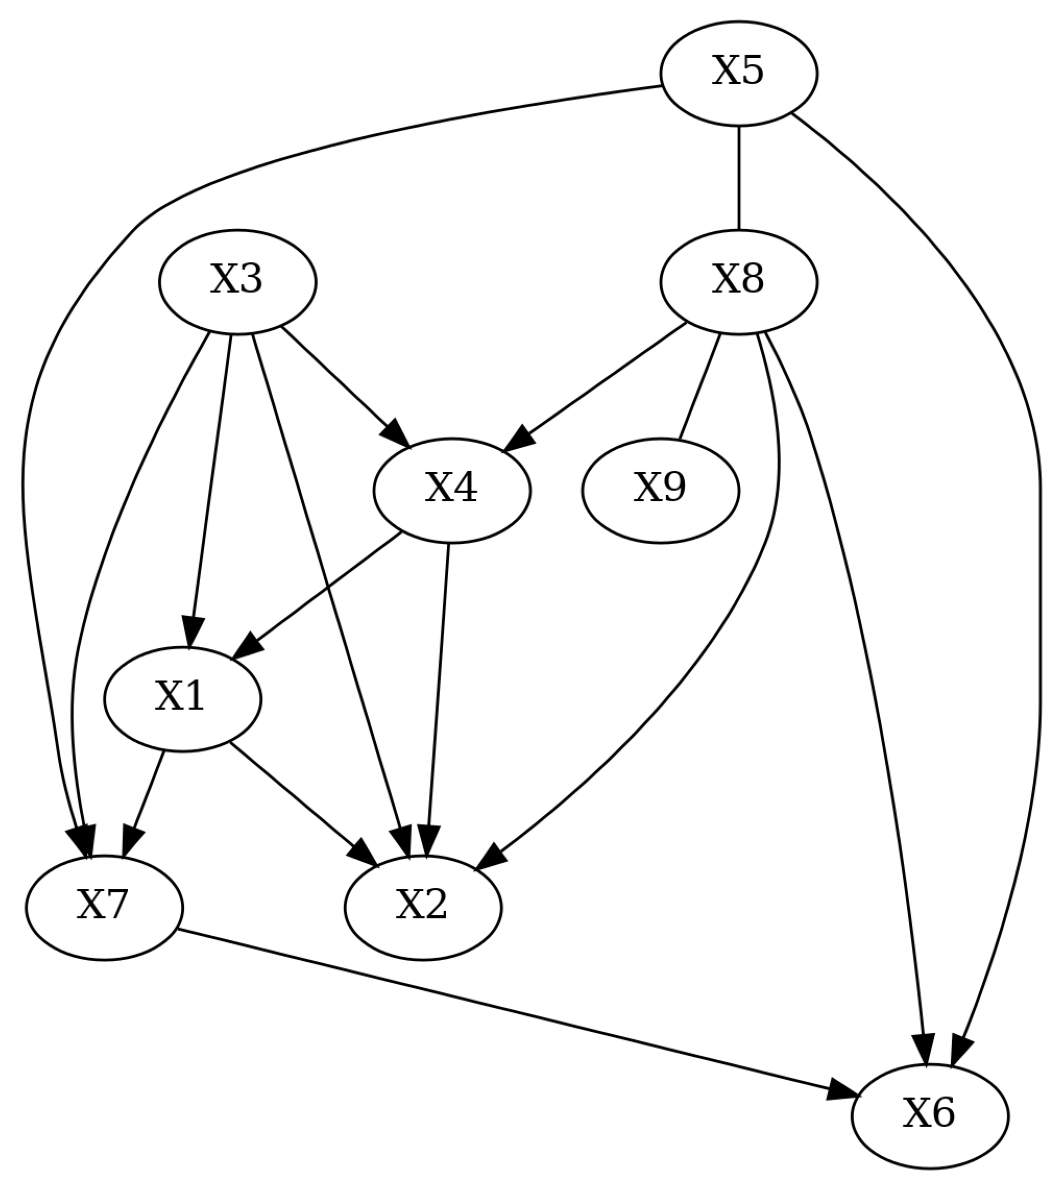

In [ ]:
#visualize and save
cg.draw_pydot_graph()
pyd = GraphUtils.to_pydot(cg.G,labels=final_df.columns)
output_file = 'result_pc.png'
pyd.write_png(output_file)

nodes_alloc
nodes_alloc
cpus_req
cpus_req
mem_req
mem_req
partition
partition
runtime
runtime
system_load
system_load
node_hours
node_hours
user_job_frequency
user_job_frequency
status
status


In [ ]:
from causallearn.search.ScoreBased.GES import ges

record = ges(final_df)


In [105]:
pyd = GraphUtils.to_pydot(record['G'])

pyd.write_png('result_ges.png')

In [97]:
#mapping of nodes to actual names
col_mapping = {f"x{i+1}": col for i, col in enumerate(final_df.columns)}
print(col_mapping)

{'x1': 'nodes_alloc', 'x2': 'cpus_alloc', 'x3': 'mem_alloc_bin', 'x4': 'num_alloc_gpus', 'x5': 'node_hours_bin', 'x6': 'status', 'x7': 'user_job_frequency', 'x8': 'system_load'}


In [109]:
from sklearn.preprocessing import StandardScaler


In [112]:
df_res

,nodes_alloc,cpus_alloc,mem_alloc,partition,num_alloc_gpus,runtime,system_load,node_hours,user_job_frequency,status
0,1,20,170000,2,0.0,0.085556,1.0,0.085556,7972,0
1,1,20,170000,2,0.0,0.110278,2.0,0.110278,7972,0
2,1,20,170000,2,0.0,0.090833,2.0,0.090833,7972,0
3,1,40,340000,2,0.0,1.069722,155.0,1.069722,479,1
4,1,20,170000,2,0.0,0.085278,3.0,0.085278,7972,0
...,...,...,...,...,...,...,...,...,...,...
395909,1,1,51200,4,0.0,0.106111,26.0,0.106111,375,0
395910,1,1,51200,4,0.0,0.170833,24.0,0.170833,375,0
395911,1,1,51200,4,0.0,0.118056,23.0,0.118056,375,0
395912,1,1,51200,4,0.0,0.134444,23.0,0.134444,375,0


In [120]:
select_cols = ['nodes_alloc', 
'cpus_alloc', 
'mem_alloc', 
'num_alloc_gpus',
 #'priority',
 #'timelimit', 
 #'job_type', 
 'runtime',
 'system_load',
 'node_hours',
 'user_job_frequency'] 
scaler = StandardScaler()
std_df_res = df_res
std_df_res [select_cols]= scaler.fit_transform(std_df_res[select_cols])


/tmp/ipykernel_17530/1703270651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_df_res [select_cols]= scaler.fit_transform(std_df_res[select_cols])


In [123]:
select_cols = ['nodes_alloc', 
'cpus_alloc', 
'mem_alloc', 
'num_alloc_gpus',
 'runtime',
 'system_load',
 'node_hours',
 'user_job_frequency',
 'status'] 

final_df = std_df_res[select_cols]

In [130]:
data = final_df.to_numpy()

In [133]:
record = ges(data)


In [134]:
pyd = GraphUtils.to_pydot(record['G'],labels=['nodes_alloc', 
'cpus_alloc', 
'mem_alloc', 
'num_alloc_gpus',
 'runtime',
 'system_load',
 'node_hours',
 'user_job_frequency',
 'status'] )

pyd.write_png('result_ges.png')

In [126]:
#mapping of nodes to actual names
col_mapping = {f"x{i+1}": col for i, col in enumerate(final_df.columns)}
print(col_mapping)

{'x1': 'nodes_alloc', 'x2': 'cpus_alloc', 'x3': 'mem_alloc', 'x4': 'num_alloc_gpus', 'x5': 'runtime', 'x6': 'system_load', 'x7': 'node_hours', 'x8': 'user_job_frequency', 'x9': 'status'}


In [129]:
final_df

,nodes_alloc,cpus_alloc,mem_alloc,num_alloc_gpus,runtime,system_load,node_hours,user_job_frequency,status
0,-0.017549,0.011905,0.048674,-0.111351,-0.248625,-0.567428,-0.165091,-0.360043,0
1,-0.017549,0.011905,0.048674,-0.111351,-0.247621,-0.566935,-0.164490,-0.360043,0
2,-0.017549,0.011905,0.048674,-0.111351,-0.248410,-0.566935,-0.164963,-0.360043,0
3,-0.017549,0.062087,0.151129,-0.111351,-0.208657,-0.491466,-0.141164,-0.791236,1
4,-0.017549,0.011905,0.048674,-0.111351,-0.248636,-0.566441,-0.165098,-0.360043,0
...,...,...,...,...,...,...,...,...,...
395909,-0.017549,-0.035768,-0.022923,-0.111351,-0.247790,-0.555096,-0.164591,-0.797221,0
395910,-0.017549,-0.035768,-0.022923,-0.111351,-0.245162,-0.556083,-0.163018,-0.797221,0
395911,-0.017549,-0.035768,-0.022923,-0.111351,-0.247305,-0.556576,-0.164301,-0.797221,0
395912,-0.017549,-0.035768,-0.022923,-0.111351,-0.246639,-0.556576,-0.163902,-0.797221,0


In [140]:
from causallearn.search.FCMBased import lingam

In [141]:
model = lingam.ICALiNGAM()
model.fit(data)

In [146]:
print(model.causal_order_)
print(model.adjacency_matrix_)

[np.int64(1), np.int64(2), np.int64(0), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(7)]
[[ 0.00000000e+00  8.26696628e-01  1.71637239e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  9.86192973e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.68532100e+00 -7.54579539e+00  5.08308891e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.97583495e-01  9.84946265e-01 -5.13955303e-01  1.21486654e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.19877969e-01 -9.44627356e-01  4.48097419e-01 -1.11760593e-01
   7.28796009e-01  0.00000000e+00  0.00000000e+00  0.00000000

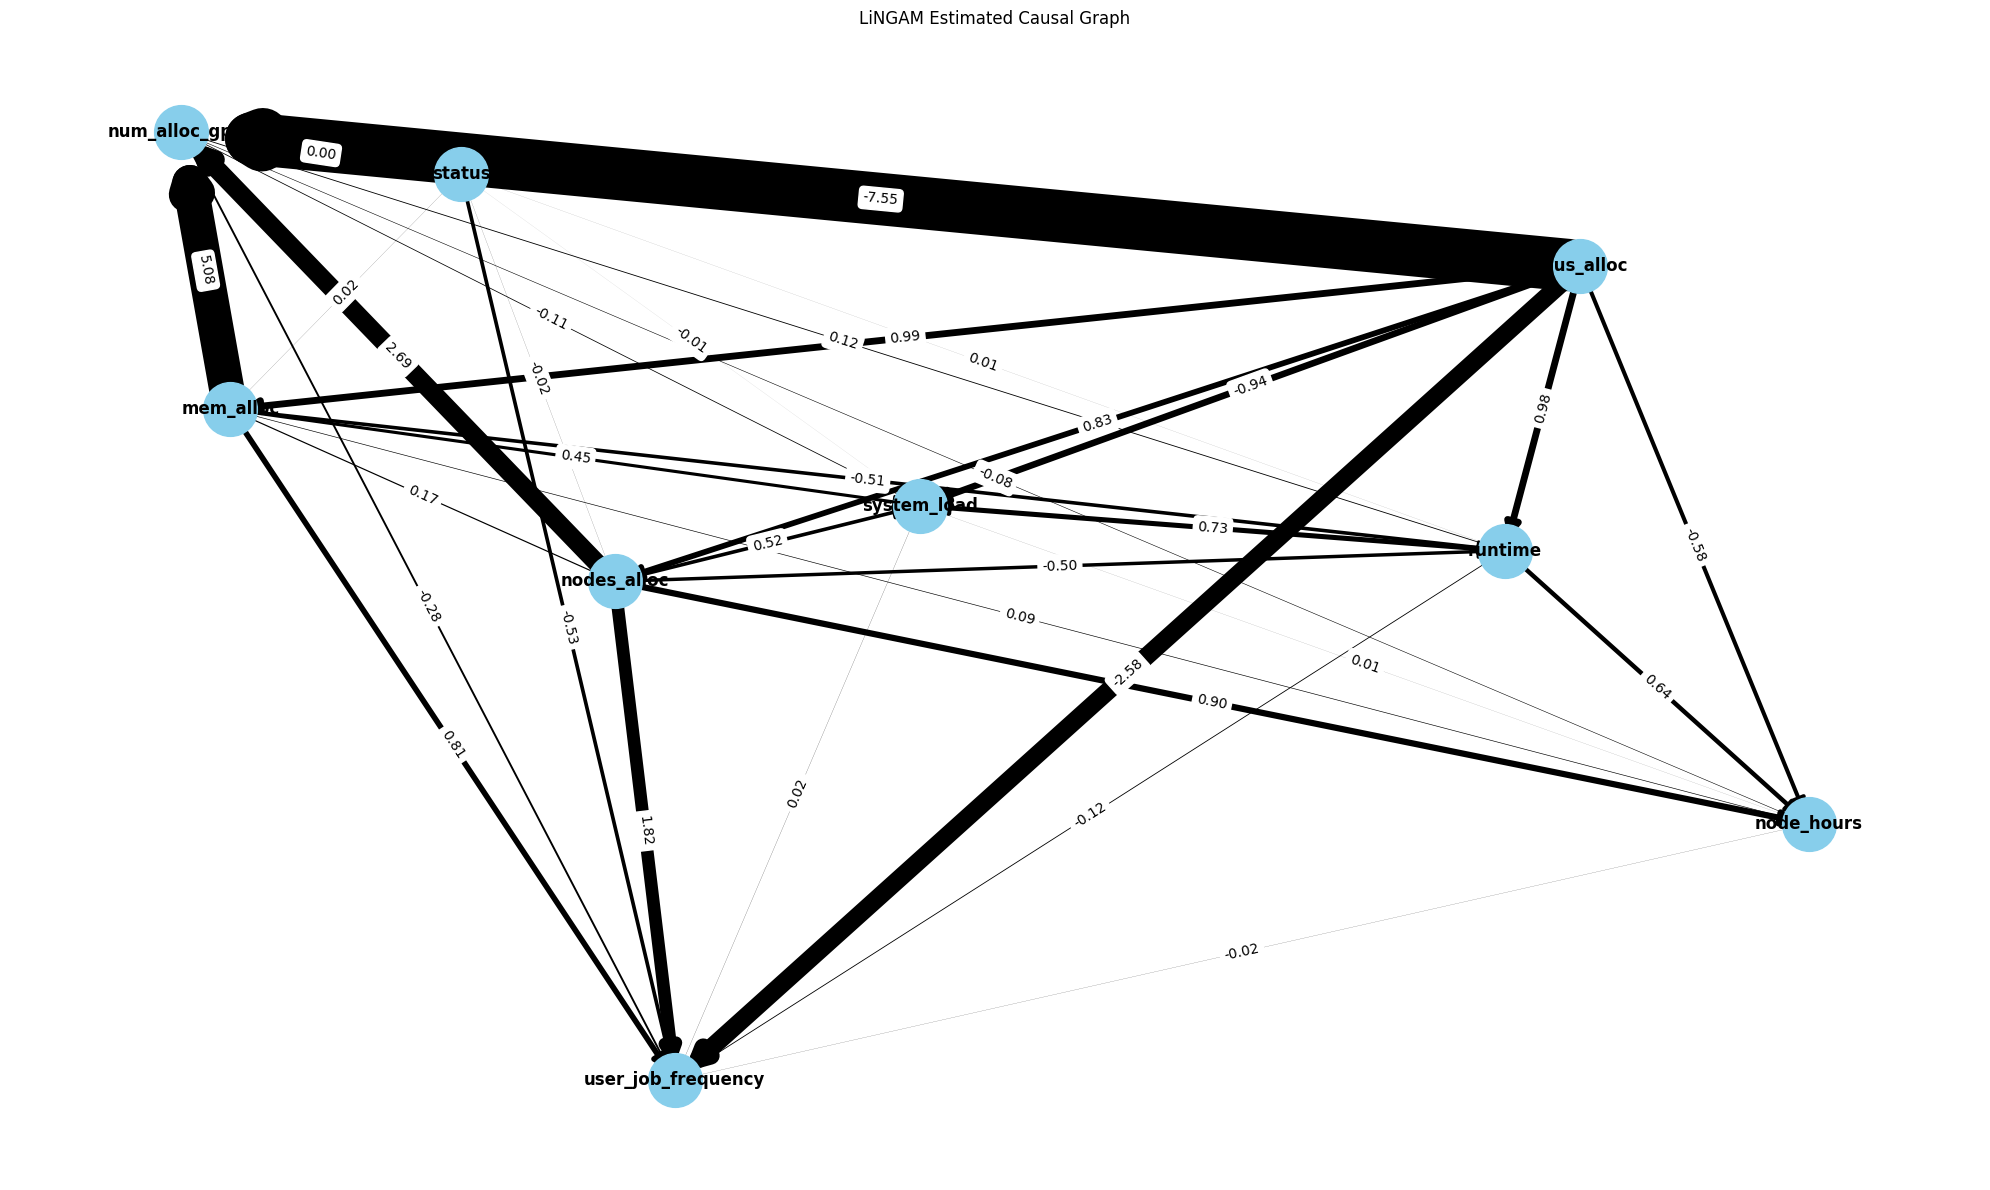

In [144]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# B = adjacency matrix from LiNGAM
B = model.adjacency_matrix_
var_names = final_df.columns  # list of variable names

G = nx.DiGraph()

# add edges with weights
for i, child in enumerate(var_names):
    for j, parent in enumerate(var_names):
        if B[i,j] != 0:
            G.add_edge(parent, child, weight=B[i,j])

# positions
pos = nx.spring_layout(G, seed=42)

# draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1500)

# draw edges with width proportional to magnitude
edges = G.edges()
weights = [abs(G[u][v]['weight'])*5 for u,v in edges]  # scale factor for visibility
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, arrowstyle='-|>', arrowsize=20, edge_color='black')

# draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# edge labels with signed coefficient
edge_labels = {(u,v): f"{G[u][v]['weight']:.2f}" for u,v in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("LiNGAM Estimated Causal Graph")
plt.axis('off')
plt.show()


In [ ]:
df = pd.read_csv('/home/cc/slurm_log_buff.csv')